In [2]:
import pandas as pd
import numpy as np

import pickle as pk
import xgboost as xgb
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option("display.max_rows", 8)

In [42]:
df = pd.read_pickle("../../data/df.pkl")
#df

### IA Filter

In [43]:
df = df.loc[df.type_bool == True]
df

,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP,wavelets,...,f14,f15,f16,f17,f18,f19,f20,type,type_bool,REDSHIFT_SPEC
ID,,,,,,,,,,,,,,,,,,,,,
SN10005,"[[10.027000000001863, 4.996, 8.081], [33.94500...","[[0.015000000006693881, 0.2977, 2.206], [18.94...","[[0.0, 1.033, 1.325], [13.015000000006694, 0.4...","[[0.03500000000349246, 1.826, 3.029], [48.875,...","[0.0, 1.0381919191919462, 2.0763838383838924, ...","([10.027000000001863, 10.782565656567513, 11.5...","([0.015000000006693881, 1.0530404040470573, 2....","([0.0, 1.0281717171717606, 2.056343434343521, ...","([0.03500000000349246, 1.0222929292964054, 2.0...","[2.000004411755352, 2.000003547336676, 2.00000...",...,-26.554909,15.768490,16.436792,17.114795,-20.292951,-24.222566,-11.295562,Ia,True,1.08327
SN10007,"[[0.0, 6.266, 10.48], [10.105999999999767, 17....","[[0.03200000000651926, 7.161, 9.313], [2.01600...","[[2.0, 1.24, 2.429], [10.121000000006461, 20.0...","[[0.9770000000062282, 0.6586, 5.329], [15.9930...","[0.0, 1.5136565656566285, 3.027313131313257, 4...","([0.0, 1.5132626262626456, 3.0265252525252913,...","([0.03200000000651926, 1.5451717171782005, 3.0...","([2.0, 3.49314141414145, 4.9862828282829, 6.47...","([0.9770000000062282, 2.480787878794107, 3.984...","[11.341091517194192, 8.812204685737349, 6.9798...",...,-99.877031,21.670852,24.155364,-26.622112,-27.616185,-19.981432,49.299250,Ia,True,0.82331
SN100361,"[[6.957000000002154, 16.02, 23.92], [7.9690000...","[[0.023000000001047738, 4.903, 3.324], [6.9840...","[[0.0, 0.7103, 2.626], [5.9760000000023865, 5....","[[8.055000000000291, 2.567, 2.665], [15.035000...","[0.0, 1.3031111111111275, 2.606222222222255, 3...","([6.957000000002154, 8.15910101010318, 9.36120...","([0.023000000001047738, 1.315494949496019, 2.6...","([0.0, 1.3026767676768058, 2.6053535353536117,...","([8.055000000000291, 9.27674747474778, 10.4984...","[8.233549869515556, 9.464488874691614, 10.4511...",...,102.074783,-95.727930,4.861555,-29.749073,23.442440,5.441237,12.503390,Ia,True,0.90012
SN100471,"[[0.0, 3.79, 4.764], [11.969000000004598, 1.67...","[[0.023999999997613486, 2.202, 3.146], [3.0429...","[[0.008000000001629815, 0.4567, 2.129], [3.004...","[[0.046999999998661224, 6.92, 2.486], [3.07500...","[0.0, 1.4638181818181601, 2.9276363636363203, ...","([0.0, 1.3621414141414037, 2.7242828282828073,...","([0.023999999997613486, 1.4875757575733735, 2....","([0.008000000001629815, 1.3701818181834458, 2....","([0.046999999998661224, 1.3283737373723963, 2....","[5.63245418874034, 5.603687474301877, 5.594769...",...,-40.831628,28.629443,12.801879,-0.555542,13.065768,-21.776767,9.358561,Ia,True,0.92640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN99404,"[[0.0, 6.586, 10.48], [15.980999999999767, 166...","[[22.0, 3.161, 11.98], [40.97700000000623, 15....","[[0.01600000000325963, 8.663, 7.843], [2.0, 1....","[[15.993000000002212, 5.828, 6.542], [29.95700...","[0.0, 1.745343434343478, 3.490686868686956, 5....","([0.0, 1.7352424242424678, 3.4704848484849355,...","([22.0, 23.382101010101024, 24.76420202020205,...","([0.01600000000325963, 1.7511212121244906, 3.4...","([15.993000000002212, 17.57679797980021, 19.16...","[475.9257034984372, 265.54157358525424, 120.22...",...,496.744492,-1269.560018,826.117566,-2224.164801,66.007045,341.497556,-173.911137,Ia,True,0.89529
SN99438,"[[0.0, 2.33, 2.55], [7.894000000000233, 3.805,...","[[0.030999999995401595, 0.006543, 3.683], [7.9...","[[0.014999999999417923, 0.4446, 1.3], [14.0039...","[[0.06199999999807915, 1.497, 4.486], [7.97199...","[0.0, 1.7255757575757058, 3.4511515151514116, ...","([0.0, 1.6948383838383538, 3.3896767676767077,...","([0.030999999995401595, 1.75597979797521, 3.48...","([0.014999999999417923, 1.7298888888882826, 3....","([0.06199999999807915, 1.7869494949475417, 3.5...","[6.789900493579756, 7.110462975693107, 7.57937...",...,-3.768615,-34.417710,32.878026,-33.942007,34.613437,61.324861,-51.210871,Ia,True,0.75966
SN99457,"[[0.0, 10.06, 4.

### Interpolation Points filter

In [44]:
dfs = {}
for cut in [2,3,4,5,6,7,8,9,10]:
    mask = (df.desg.str.len() > cut) & (df.desi.str.len() > cut) & (df.desr.str.len() > cut) & (df.desz.str.len() > cut) 
    dfs['df_cut'+str(cut)] = df.loc[mask]

In [45]:
for key in dfs.keys():
    regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
    X = dfs[key].loc[:,'f1':'f20']
    y = np.array(dfs[key].REDSHIFT_SPEC)
    ans_real_19 = linear_regression(X, y, int(len(dfs[key])/1100), 5, regressor)
    ans_real_2 = linear_regression(X, y, 2, 5, regressor)
    ans_normal = normal_linear_regression(X, y, 5, regressor)
    print(f'\n \n \n Values for {key}' + f'. DF len = {len(X)}' + '\n')
    evaluate(ans_real_19, ans_real_2, ans_normal)


 
 
 Values for df_cut2. DF len = 5047

 RMSE Means : 
 
 Validate 19:  0.17523837546419674 
 Validate 2:  0.16867416902872573 
 No Validation:  0.16332330875137668

 MAE Means : 
 
 Validate 19:  0.1423576067427603 
 Validate 2:  0.13631383152670593 
 No Validation:  0.13185943404405026

 
 
 Values for df_cut3. DF len = 4930

 RMSE Means : 
 
 Validate 19:  0.17509201572448074 
 Validate 2:  0.16831202922283878 
 No Validation:  0.16302307070303132

 MAE Means : 
 
 Validate 19:  0.14226952695788414 
 Validate 2:  0.13616588173135522 
 No Validation:  0.13154750892776698

 
 
 Values for df_cut4. DF len = 4751

 RMSE Means : 
 
 Validate 19:  0.17536111574555627 
 Validate 2:  0.16808839939241713 
 No Validation:  0.16277862248306113

 MAE Means : 
 
 Validate 19:  0.14238601594002628 
 Validate 2:  0.13594744753062155 
 No Validation:  0.13149904193453787

 
 
 Values for df_cut5. DF len = 4551

 RMSE Means : 
 
 Validate 19:  0.17578101059837992 
 Validate 2:  0.16838883910649313 

#### Fake Optimal value: Cut = 6
##### RMSE value Before cut: 0.175454
##### RMSE value with cut  6: 0.17286
    Note: Validate 19 on "Only IA Filter" isnt 19, it's more or less 5.Considering it, we should consider validate 2 (and maybe test on other samples which were cut off)
    
#### Real (validate 2) Optimal value: Cut = 4
##### RMSE value Before cut: 0.16885
##### RMSE value with cut  4: 0.16808

    Note2: For only 8^10-4 RMSE improvement, it isnt worth cut values.

## Regression filtering only values within mean +- std

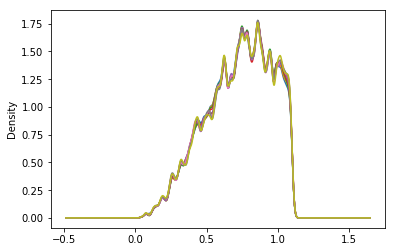

In [46]:
for key in dfs.keys():
    dfs[key].REDSHIFT_SPEC.plot.kde(bw_method=0.05)

#### Results are similar, no significant group discarded.
##### No need to filter by quantiles or analyse boxplot.

In [30]:
def divide_validation(X, y, splits):
    """
    Divides DF in {splits} splits, in order to destinate ~ 1100 to normal 80-20 train and test.
    Then we Validate with the ~ {len(df) - splits} lines
    """
    kf = KFold(n_splits = splits)
    X_validate = [] # List with Xs to validate
    X_train_test = []  # List with Xs to train and test
    y_validate = [] # List with ys to validate
    y_train_test = []  # List with ys to train and test

    for train_index_real, test_index_real in kf.split(X):
        #print("X_validate:", train_index_real, "X_train_test:", test_index_real)
        X_validate.append(X.iloc[train_index_real])
        X_train_test.append(X.iloc[test_index_real])
        y_validate.append(y[train_index_real])
        y_train_test.append(y[test_index_real])

    return (X_train_test, X_validate, y_train_test, y_validate)

def Kfold(X, y, splits):
    """
    Normal K-Fold
    """
    kf = KFold(n_splits = splits)
    X_train, X_test, y_train, y_test = [], [], [], []

    for train_index, test_index in kf.split(X):
        X_train.append(X.iloc[train_index])
        X_test.append(X.iloc[test_index])
        y_train.append(y[train_index])
        y_test.append(y[test_index])
    return (X_train, X_test, y_train, y_test)

def linear_regression(X, y, splits_validation, splits_KFold, regressor):
    """
    Divides DF in splits_validation splits, in order to destinate ~ 1100 to ordinary K-Fold 80-20 train and test.
    Then we Validate with the other rows
    It saves the specific elemnts that will be analysed in a dict format.
    Returns a list of dict with specified keys. Each element corresponds to one K-Fold test inside a splits_validation group. List
    lenght is equal to splits_validation * splits_KFold.
    
    Args:
        X (pandas.core.frame.DataFrame) : Data Frame with colunmns as features and rows as objects (Training data)
        y (numpy.ndarray) : Target values 
        splits_validation (int) : Number of Validation splits, it will divide entire data in splits_validation (it should be int(len(df)/1100))
        splits_KFold (int) : Number of K-Folds splits
        regressor (xgboost.sklearn.XGBRegressor) : Regressor parameter from XGBoost
        
    Returns:
        list: return list of dict with specified keys. Each element corresponds to one K-Fold test inside a splits_validation group.
        
    """
    ans = []
    X_train_test, X_validate, y_train_test, y_validate = divide_validation(X, y, splits_validation)
    for i in range(len(X_validate)):
        X_train, X_test, y_train, y_test = Kfold(X_train_test[i], y_train_test[i], splits_KFold)
        for j in range(len(X_train)):
            element = dict.fromkeys(['preds_arr','rmse_arr','mae_arr','r2_arr','matrices_arr','true_preds','true_rms','true_mae','true_r2','models'])
            
            regressor.fit(X_train[j],y_train[j]) #Overwrites last data, do not do Incremental learning
            #print("Fitting " + str(j+1) + 'th model from ' + str(i+1) + 'th validation' )
            element['preds_arr'] = regressor.predict(X_test[j])
            element['rmse_arr'] = np.sqrt(mean_squared_error(y_test[j], element['preds_arr']))
            element['mae_arr'] = mean_absolute_error(y_test[j], element['preds_arr'])
            element['r2_arr'] = r2_score(y_test[j], element['preds_arr'])
            element['matrices_arr'] = np.round((abs(y_test[j]-element['preds_arr'])/y_test[j])*100)
            
            element['true_preds'] = regressor.predict(X_validate[i])
            element['true_rms'] = np.sqrt(mean_squared_error(y_validate[i], element['true_preds'])) # RMES -> Aumenta com maiores variancia
            element['true_mae'] = mean_absolute_error(y_validate[i], element['true_preds'])          # MAE -> Nao varia com variancia
            element['true_r2'] = r2_score(y_validate[i], element['true_preds'])
            element['models'] = regressor
            ans.append(element)         
    return ans

def normal_linear_regression(X, y, splits_KFold, regressor):
    """
    Normal XGBoost linear regressions, dividing the entire Data Set as 80/20 train/test K-Fold. Without Validation.
    It saves the specific elemtns that will be analysed in a dict format.
    
    Args:
        X (pandas.core.frame.DataFrame) : Data Frame with colunmns as features and rows as objects (Training data)
        y (numpy.ndarray) : Target values 
        splits_KFold (int) : Number of K-Folds splits
        regressor (xgboost.sklearn.XGBRegressor) : Regressor parameter from XGBoost
        
    Returns:
        list: return list of dict with specified keys. Each element corresponds to one K-Fold test.    
    """
    ans = []
    X_train, X_test, y_train, y_test = Kfold(X, y, splits_KFold)
    for j in range(len(X_train)):
        element = dict.fromkeys(['preds_arr','rmse_arr','mae_arr','r2_arr','matrices_arr','models'])
        regressor.fit(X_train[j],y_train[j]) #Overwrites last data, do not do Incremental learning
        #print("Fitting " + str(j+1) + 'th model from ' + str(i+1) + 'th validation' )
        element['preds_arr'] = regressor.predict(X_test[j])
        element['rmse_arr'] = np.sqrt(mean_squared_error(y_test[j], element['preds_arr']))
        element['mae_arr'] = mean_absolute_error(y_test[j], element['preds_arr'])
        element['r2_arr'] = r2_score(y_test[j], element['preds_arr'])
        element['matrices_arr'] = np.round((abs(y_test[j]-element['preds_arr'])/y_test[j])*100)

        element['models'] = regressor
        ans.append(element)         
    return ans

def evaluate(ans_real_19, ans_real_2, ans_normal):
    """
    TODO
    """
    list_and_mean = lambda ans, key : (np.array([i[key] for i in ans]) , np.mean(np.array([i[key] for i in ans])))
    l_19, mean_19 = list_and_mean(ans_real_19, 'true_rms')
    l_2, mean_2 = list_and_mean(ans_real_2, 'true_rms')
    l, mean = list_and_mean(ans_normal, 'rmse_arr')
    print(" RMSE Means : \n", 
         "\n Validate 19: ", mean_19,
         "\n Validate 2: ", mean_2,
         "\n No Validation: ", mean)
    l_19, mean_19 = list_and_mean(ans_real_19, 'true_mae')
    l_2, mean_2 = list_and_mean(ans_real_2, 'true_mae')
    l, mean = list_and_mean(ans_normal, 'mae_arr')
    print("\n MAE Means : \n", 
         "\n Validate 19: ", mean_19,
         "\n Validate 2: ", mean_2,
         "\n No Validation: ", mean)